# Sparseloop Tutorial - 02 - Matrix Multiply

This notebook contains a series of examples of a **matrix multiply** computation. The **fibertree** emulator is used to illustrate the impact of a set of optimizations to exploit sparsity. The basic computation is represented by the Einsum:

$$ Z_{m,n} = A_{m,k} \times B_{k,n} $$

Note that while the output is nominally a sparse rank-2 tensor, in this notebook the output is assumed to be in an uncompressed format and is directly referenced by **coordinate** since **position** == **coordinate** in an uncompressed format.

First, include some libraries

In [5]:
# Run boilerplate code to set up environment

%run ./prelude.py --style=tree --animation=movie

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Configure two rank-2 input tensors

The following cell sets up the control sliders to specify the attributes of the `A` and `B` input tensors. Those attributes include their **shape**, which specifies the allowable range of **coordinates** of elements of the tensor and their **density**.

The rank names use the following convention:

- M - uncontracted dimension in input `A`
- N - uncontracted dimension in input `B`
- K - contracted dimension shared by `A` and `B`



In [10]:
#
# Set default problem instance attributes (i.e., the shape of the tensors)
#
FORMAT_CYCLES = 2
FORMAT_HBM_CHANNELS = 2
FORMAT_HBM_BANK_WIDTH = 4
FORMAT_HBM_BANK_DEPTH = 100
K = 4
I = 4
J = 2

#
# Create controls to configure the `A` and `B` tensors
#
tm2 = TensorMaker("sparseloop-matrix-multiply", autoload=True)

tm2.addTensor("A", rank_ids=["FMT_CYCLES", "FMT_HBM_CHAN", "I", "K"], shape=[FORMAT_CYCLES,FORMAT_HBM_CHANNELS,I, K], density=0.4, color="blue")
tm2.addTensor("B", rank_ids=["FMT_CYCLES", "FMT_HBM_CHAN", "K", "J"], shape=[FORMAT_CYCLES, FORMAT_HBM_CHANNELS, K, J], density=0.5, color="green")

tm2.displayControls()


2021-08-10 05:49:34,856 Control file (sparseloop-matrix-multiply.yaml) does not exist


interactive(children=(Label(value='Tensor Creation Controls', description='Title'), Label(value='Tensor A', de…

## Create and display the input tensors

Create the `A` and `B` tensors based on the current settings of the configuration sliders above and display the resulting tensors. These tensors are represented in the **fibertree** tensor abstraction, where for sparse fibers only the **elements** (**coordinate**/**payload** tuples) in a fiber with **non-empty** (non-zero) payloads need be shown.

TODO:
* Understand how format channel width is determined - max vectorized read width?
* Capture encoding process
* Capture the relationship between formatted and unformatted tensor
* Capture all of the below
* Capture a dense represntation of the format

## Details:
* The number of C2SR channels (FMT_HBM_CHAN) corresponds to the number of HBM banks
* Each ordered pair of *(C2SR cycle, C2SR channel)* is associated with a subtensor "tile" containing nonzero elements of the underlying tensor.
* Tile size (cardinality) is always less than or equal to the HBM bank vectorized access *width* (which determines the "width" of C2SR "format channels")
* Each HBM bank has an effective "depth" corresponding to how many vectorized writes' worth of data could fill the bank. This corresponds to the number of C2SR "cycles" (FMT_CYCLES)
* Each format channel coordinate *n* (HBM bank index *n*) is associated with a unique row parity. (i.e. even/odd for 2 channels, *k mod N* for *N* channels)
* All tiles associated with channel *n* store nonzero elements only from rows that match the row parity associated with channel *n*
* From a packing perspective, the nonzero elements of the tensor ranks are packed with 100% density into the shallowest vector slots of the HBMs (i.e. the *format* has 100% density in the lowest cycle coordinates; of course the underlying tensor is sparse).
* For a given format channel with parity *k*, if the total data size of the *k*-parity rows is less than the bank size, then all HBM vector slots past a certain depth will be zero (i.e. the format channel will be empty for higher cycle coordinates of the format)
* If the data size of the parity-*k* rows is not an integer multiple of the vectorized access width, then the deepest populated HBM vector slot may be partially-filled
* The aggregate sparsity of the parity-*k* rows may differ for different *k*; therefore some HBM banks will be filled to a greater depth
* This means that some cycles of the C2SR representation will have a mixture of empty format channels, <100% dense format channels, and 100% dense format channels

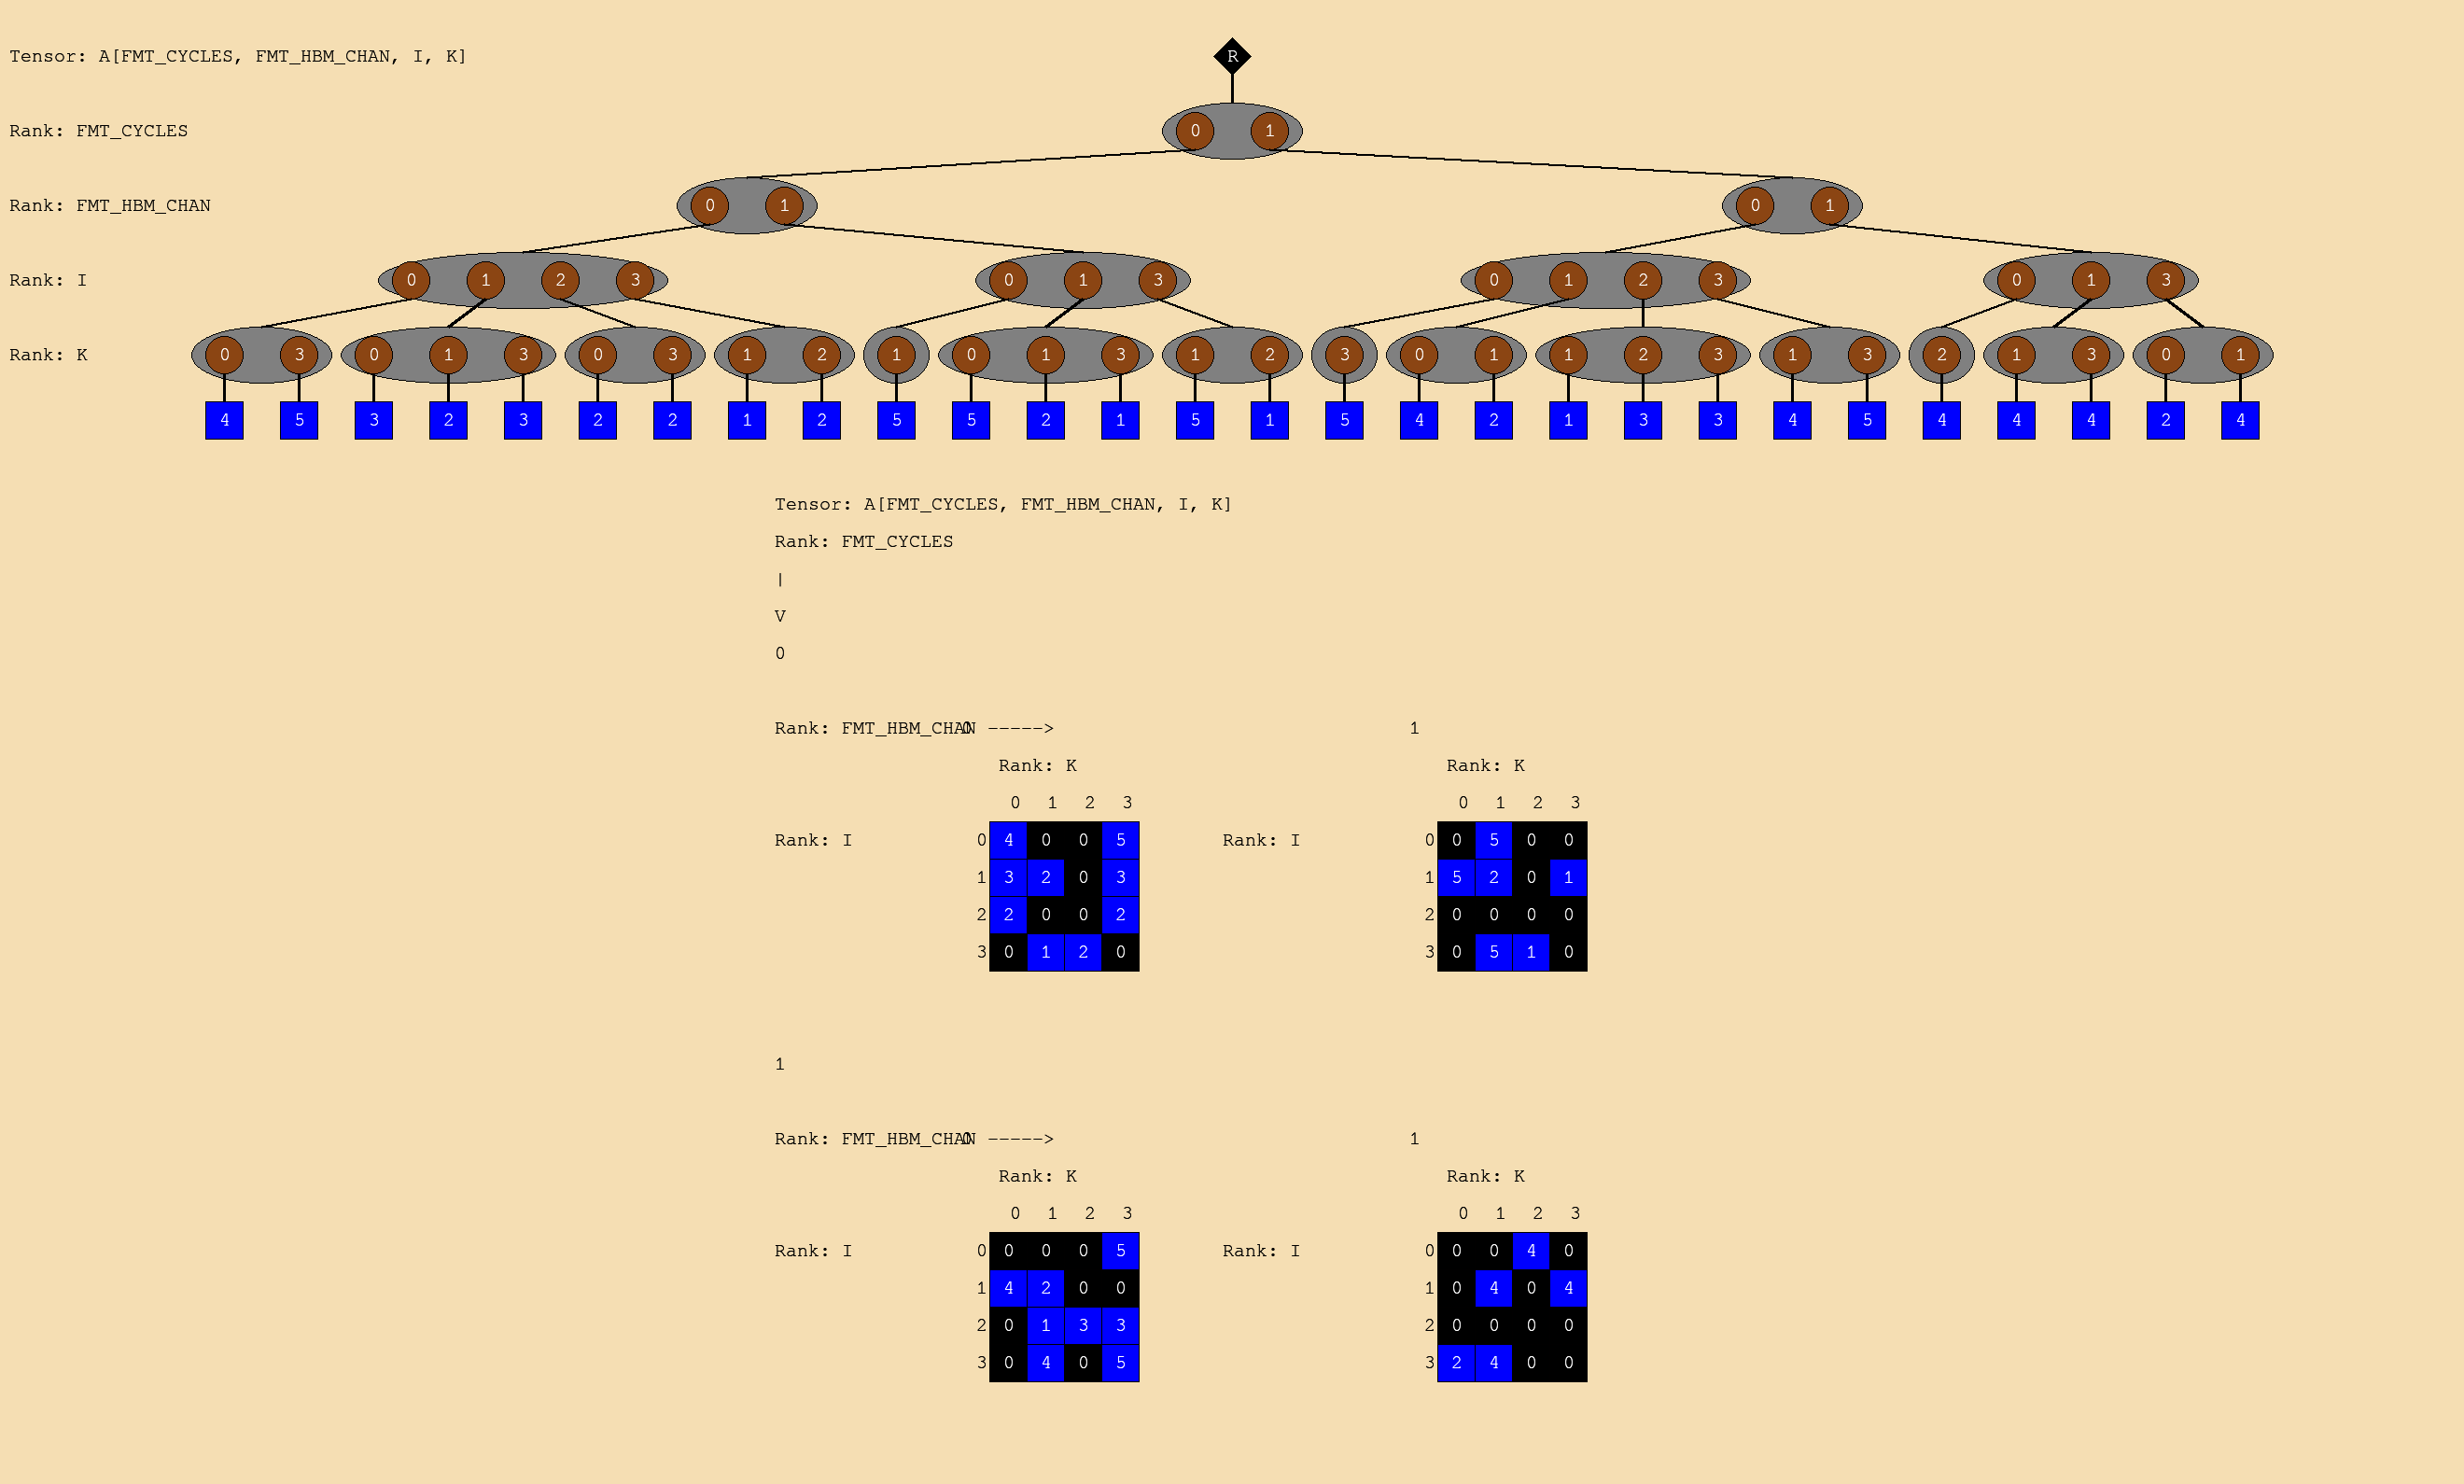

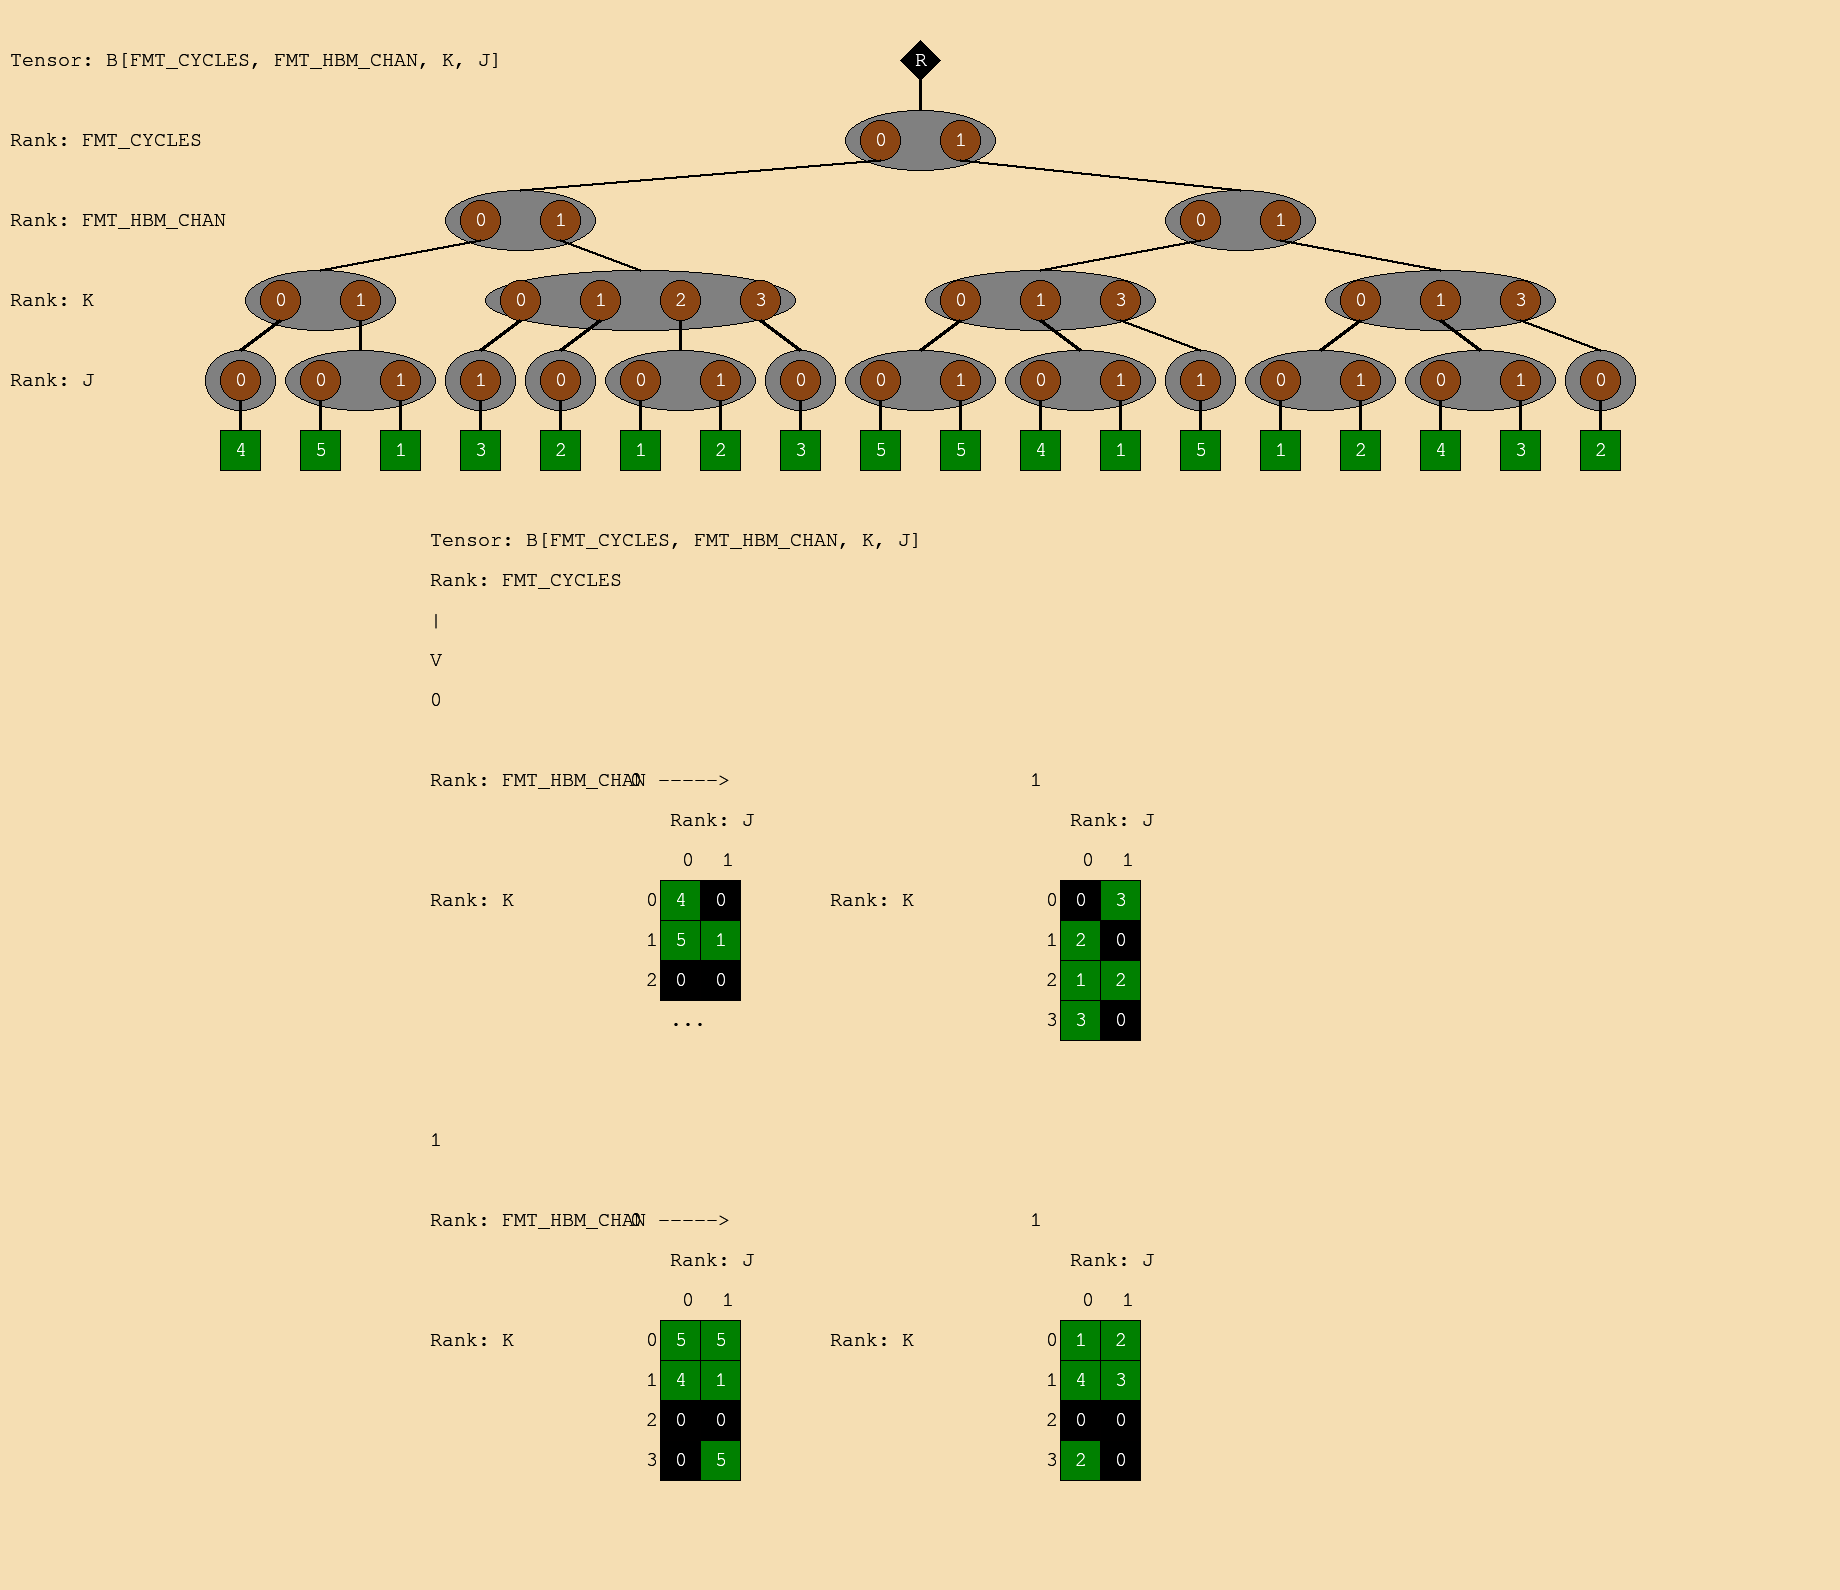

In [11]:
A_CYCH_IK = tm2.makeTensor("A")
B_CYCH_KJ = tm2.makeTensor("B")

displayTensor(A_CYCH_IK)
displayTensor(B_CYCH_KJ)

# Sparse A loader (spAL) 

MatRaptor implements an original tiled row-wise dataflow called Row-wise Product. The tiling is implicit, resulting from how C2SR maps to the HBM banks.

Row-wise product follows a JKI permutation at the PE level. At the whole-architecture level, C2SR imposes a tiling over the memory hierarchy.

The MatRaptor assigns 

As a simple illustration of the traversal of a rank-2 tensor, the following code shows how that can be accomplished with two nested `for` loops where the **payload** of the traversal of the top rank is a reference to a **fiber** in the next rank.

This natural traversal order where the bottom rank is traversed fastest (i.e., in a depth first fashion) is referred to as a **concordant** traversal and tend to be the most efficient. Other, less efficient, traversal orders are referred to as **discordant**.


In [12]:
#
# Create a rank-2 tensor
#
A_CYCH_IK = tm2.makeTensor("A")

#uncompressTensor(A_CYCH_MK)

#
# Get root of tensor
#
a_cy = A_CYCH_IK.getRoot()

#
# Animation bookkeeeping
#
canvas = createCanvas(A_CYCH_IK)

cycle = 0

for cy, a_ch in a_cy:
    #
    # Iterate over all row indices
    #
    for idx in range(I):
        cycle = 0
        #
        # For each nonempty channel
        #
        for ch, a_i in a_ch:       
            # Channel parity match
            if ch == (idx % FORMAT_HBM_CHANNELS):
                #
                # Traverse non-empty elements of top rank
                #
                for m, a_k in a_i:   
                    # Row match
                    if m == idx:
                        #
                        # Traverse non-empty element of bottom rank
                        #
                        for k, a_val in a_k:  

                            print(f"{a_val} ", end='')

                            #
                            # Animation bookkeeping
                            #
                            canvas.addActivity((cy,ch,idx,k), worker=f"PE{idx}")
                            cycle += 1
    canvas.addFrame()

displayCanvas(canvas)

<4> <5> <5> <2> <1> <2> <2> <5> <1> <5> <4> <4> <1> <3> <3> <2> <4> 

# Sparse B loader (spBL) 

From spAL, the spBL receives a single item from coordinates *(i,k)* of *A*. For each *A* item spBL receives, spBL loads the entire row *k* of *B*. 




In [13]:
#
# Create a rank-2 tensor
#
A_CYCH_MK = tm2.makeTensor("A")

#uncompressTensor(A_CYCH_MK)

#
# Get root of tensor
#
a_cy = A_CYCH_MK.getRoot()

#
# Animation bookkeeeping
#
canvas = createCanvas(A_CYCH_MK)

cycle = 0

for cy, a_ch in a_cy:
    uncompressTensor(a_ch)
    #
    # Iterate over all row indices
    #
    for m in range(M):
        cycle = 0
        #
        # For each nonempty channel
        #
        for ch, a_m in a_ch:       
            # Channel parity match
            if ch == (m % FORMAT_HBM_CHANNELS):
                print(str(ch))
                #
                # Traverse non-empty elements of top rank
                #
                for midx, a_k in a_m:   
                    # Row match
                    if midx == m:
                        #
                        # Traverse non-empty element of bottom rank
                        #
                        for k, a_val in a_k:  

                            #print(f"{a_val} ", end='')

                            #
                            # Animation bookkeeping
                            #
                            canvas.addActivity((cy,ch,m,k), spacetime=(0,cycle))
                            cycle += 1

displayCanvas(canvas)

AttributeError: 'Fiber' object has no attribute 'getRoot'

# TODO: multiply two C2SR-formatted tensors

The following code illustrates the traversal and accesses associated with the computation of untiled matrix multiply as expressed by the following Einsum:

$$ Z_{m,n} = A_{m,k} \times B_{k,n} $$

In [ ]:
#
# Create the input/output tensors
#
K = getShape(tm2, "K")
M = getShape(tm2, "M")
N = getShape(tm2, "N")

A_MK = tm2.makeTensor("A")
B_KN = tm2.makeTensor("B")

Z_MN = Tensor(name="Z", rank_ids=["M", "N"], shape=[M, N])

uncompressTensor(Z_MN)

#
# Display the tensors
#
print("Problem instance:")
print(f"M: {M}")
print(f"K: {K}")
print(f"N: {N}")
print("")

print("Input A")
displayTensor(A_MK)
print("Input B")
displayTensor(B_KN)
print("Output Z (initial)")
displayTensor(Z_MN)

#
# Get the root fibers of each tensor
#
a_m = A_MK.getRoot()
b_k = B_KN.getRoot()
z_m = Z_MN.getRoot()

#
# Animation bookkeeping
#
canvas = createCanvas(A_MK, B_KN, Z_MN)

cycle = 0

#
# Traverse non-empty elements of top rank of `A`
#
for m, a_k in a_m:
    #
    # Traverse the K rank of `A`
    #
    for k, a_val in a_k:
        #
        # Obtain the matching fiber in `B`
        #
        b_n = b_k.getPayload(k)
        
        #
        # Traverse the bottom rank of `B`
        #
        for n, b_val in b_n:
            #
            # Do the reduction
            #
            z_m[m][n] += a_val * b_val
            
            #
            # Animation bookkeeping
            #
            canvas.addActivity((m,k), (k,n), (m, n), spacetime=(0,cycle))
            cycle += 1
            
#
# Display results
#
print("Output tensor Z (final)")
displayTensor(Z_MN)

displayCanvas(canvas)

# TODO: is matraptor dataflow identical to Tiled Matrix Multiply?

$$ Z_{n1,m,n0} = A_{m,k} \times B_{n1,k,n0}$$

## Splitting of B

First we look at the sequence for splitting the `B` tensor along the N rank.

Notes:

- The coordinates in the N0 rank are the original N coordinates
- We are assuming that this is done offline... Online tiling is beyond the scope of this notebook.

In [ ]:
#
# Create tensors
#

N0 = 3

B_KN = tm2.makeTensor("B")

print("Original B tensor")
displayTensor(B_KN)

#
# Split the `N` rank of `B` into a series of fibers with shape `N0`
# then rename the coordinates of the N1 rank to match the coordinates we want in the output (hacky)
#
B_N1N0K = B_KN.splitUniform(N0, depth=1)
B_N1N0K = B_N1N0K.updateCoords(lambda n, c, p: n, depth=1)

print("B tensor with N rank split into fibers with a shape={N0}")
displayTensor(B_N1N0K)

#
# Swizzle the ranks of B so that we can traverse it in a **concordant** fashion
#
B_N1KN0 = B_N1N0K.swapRanks()

print("B tensor split and swizzed for concordant traversal")
displayTensor(B_N1KN0)

## Tiled Matrix Multiply

In [ ]:
#
# Create the input/output tensors
#
K = getShape(tm2, "K")
M = getShape(tm2, "M")
N = getShape(tm2, "N")

N1 = 2
N0 = (N+1)//2

#
# Create tensors
#

A_MK = tm2.makeTensor("A")
B_KN = tm2.makeTensor("B")


B_N1KN0 = B_KN.splitUniform(N0, depth=1).swapRanks()
B_N1KN0 = B_N1KN0.updateCoords(lambda n, c, p: n)

Z_MN = Tensor(name="Z",
              rank_ids=["M", "N"],
                 shape=[M, N])
uncompressTensor(Z_MN)

Z_N1MN0 = Z_MN.splitUniform(N0, depth=1).swapRanks()
Z_N1MN0 = Z_N1MN0.updateCoords(lambda n, c, p: n)
Z_N1MN0.setMutable(True)

#
# Display Tensors
#
print("Problem instance:")
print(f"K:  {K}")
print(f"M:  {M}")
print(f"N:  {N}")
print(f"N1: {N1}")
print(f"N0: {N0}")

displayTensor(A_MK)
displayTensor(B_N1KN0)
displayTensor(Z_N1MN0)

#
# Get the root fibers of each tensor
#
a_m = A_MK.getRoot()
b_n1 = B_N1KN0.getRoot()
z_n1 = Z_N1MN0.getRoot()

#
# Animation bookkeeping
#
canvas = createCanvas(A_MK, B_N1KN0, Z_N1MN0)

cycle = 0

#
# Traverse non-empty elements of `N1` (top) rank of `B`
#
for n1, b_k in b_n1:
    #
    # Traverse non-empty elements of `M` (top) rank of A
    #
    for m, a_k in a_m:
        #
        # Traverse the K (bottom) rank of `A`
        #
        for k, a_val in a_k:
            #
            # Obtain the matching fiber in `B`
            #
            b_n0 = b_k.getPayload(k)
        
            #
            # Traverse the `N0` (bottom) rank of `B`
            #
            for n0, b_val in b_n0:
                #
                # Do the reduction
                #
                # Note hack to get right position in `N0` rank of `Z`
                #
                z_n1[n1][m][n0%N0] += a_val * b_val
            
                #
                # Animation bookkeeping
                #
                canvas.addActivity([(m,k)], [(n1,k,n0)], [(n1, m, n0)], 
                                   spacetime=(0,cycle))
                cycle += 1
            
displayTensor(Z_N1MN0)
displayCanvas(canvas)

## Testing area

For running alternative algorithms